# Визуализация данных

Мы будем работать с данными [kaggle-соревнования](https://www.kaggle.com/c/prudential-life-insurance-assessment)

__Задача соревнования:__ по характеристикам человека и его заявки на медицинскую страховку предсказать степень риска, характерную для данной страховки.

__Задачи:__
* изучить данные;
* пробовать разные методы визуализации;
* проанализировать графики и сделать выводы, полезные для следующих этапов решения задачи.

Целевой признак (степень риска) в задаче номинальный: целые числа от 1 до 8, а метрика качества, предложенная организаторами соревнования, оценивает степень согласованности двух рейтингов. Поэтому задачу можно решать и методами классификации, и методами регрессии (в последнем случае придется округлять предсказания). Это стоит учитывать при анализе результатов визуализации.

Мы будем визуализировать только обучающую выборку. Часто при решении конкурсов полезно визуализировать также тестовую выборку (на которой нужно сделать предсказание), чтобы убедиться, что данные идентичны.

In [1]:
import numpy as np
import pandas
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline

Считываем данные:

In [11]:
data = pandas.read_csv("train.csv", na_values="NaN")

In [12]:
pandas.options.display.max_columns = None

In [13]:
data.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_15,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,2,1,1,3,2,2,1,NaN,3,2,3,3,240.0,3,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,2,1,1,3,2,2,1,NaN,3,2,3,3,0.0,1,3,1,1,2,1,2,3,NaN,1,3,3,1,3,2,3,NaN,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,2,2,3,NaN,1,3,3,1,3,2,3,NaN,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,2,2,1,3,2,2,2,NaN,3,2,3,3,NaN,1,3,1,1,2,1,2,3,NaN,2,2,3,1,3,2,3,NaN,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 128 entries, Id to Response
dtypes: float64(18), int64(109), object(1)
memory usage: 58.0+ MB


Вы можете посмотреть описание признаков на [странице с данными](https://www.kaggle.com/c/prudential-life-insurance-assessment/data). Резюме: значение известно только для нескольких признаков, для остальных известна только группа, к которой этот признак принадлежит (например, медицинские данные) и тип признака: вещественный, целочисленный или категориальный. При этом неясно, можно ли считать категориальные признаки упорядоченными.

Создадим три списка признаков, соответствующие их группам: вещественные, целочисленные и категориальные (эти списки даны на странице соревнования). Уберем признак Id, так как он не несет смысловой нагрузки. 

Если бы типы признаков были не даны, нам бы пришлось вручную просматривать все 128 признаков, чтобы понять, какие значения они принимают. 

In [16]:
real_features = ["Product_Info_4", "Ins_Age", "Ht", "Wt", "BMI", "Employment_Info_1", "Employment_Info_4", "Employment_Info_6",
                 "Insurance_History_5", "Family_Hist_2", "Family_Hist_3", "Family_Hist_4", "Family_Hist_5"]
discrete_features = ["Medical_History_1", "Medical_History_10",
                     "Medical_History_15", "Medical_History_24", "Medical_History_32"]
cat_features = data.columns.drop(real_features).drop(
    discrete_features).drop(["Id", "Response"]).tolist()

### Первичный анализ

Есть набор стандартных приемов визуализации, которые нужно попробовать, когда вы начинаете работу с набором данных; к ним относятся построение гистограмм признаков (histogram, density estimation), л статистик, оценка зависимости целевого признака от остальных (boxplot, scatterplot, violinplot), визуализация пар признаков (как правило, scatterplot). Конкретный вид графика, который вам подходит, зависит от типа признаков, хороший обзор приведен в разделе Plotting functions [туториала seaborn](https://stanford.edu/~mwaskom/software/seaborn/tutorial.html).

Сначала рассмотрим числовые признаки, затем - категориальные.

#### Выведем статистики вещественных и целочисленных признаков:

In [17]:
data[real_features].describe()

,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_4,Employment_Info_6,Insurance_History_5,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5
count,59381.000000,59381.000000,59381.000000,59381.000000,59381.000000,59362.000000,52602.000000,48527.000000,33985.000000,30725.000000,25140.000000,40197.000000,17570.000000
mean,0.328952,0.405567,0.707283,0.292587,0.469462,0.077582,0.006283,0.361469,0.001733,0.474550,0.497737,0.444890,0.484635
std,0.282562,0.197190,0.074239,0.089037,0.122213,0.082347,0.032816,0.349551,0.007338,0.154959,0.140187,0.163012,0.129200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.076923,0.238806,0.654545,0.225941,0.385517,0.035000,0.000000,0.060000,0.000400,0.362319,0.401961,0.323944,0.401786
50%,0.230769,0.402985,0.709091,0.288703,0.451349,0.060000,0.000000,0.250000,0.000973,0.463768,0.519608,0.422535,0.508929
75%,0.487179,0.567164,0.763636,0.345188,0.532858,0.100000,0.000000,0.550000,0.002000,0.579710,0.598039,0.563380,0.580357
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.943662,1.000000


In [18]:
data[discrete_features].describe()

,Medical_History_1,Medical_History_10,Medical_History_15,Medical_History_24,Medical_History_32
count,50492.000000,557.000000,14785.000000,3801.000000,1107.000000
mean,7.962172,141.118492,123.760974,50.635622,11.965673
std,13.027697,107.759559,98.516206,78.149069,38.718774
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,8.000000,17.000000,1.000000,0.000000
50%,4.000000,229.000000,117.000000,8.000000,0.000000
75%,9.000000,240.000000,240.000000,64.000000,2.000000
max,240.000000,240.000000,240.000000,240.000000,240.000000


In [21]:
data[discrete_features].isnull().sum()

Medical_History_1      8889
Medical_History_10    58824
Medical_History_15    44596
Medical_History_24    55580
Medical_History_32    58274
dtype: int64

In [22]:
data[real_features].isnull().sum()

Product_Info_4             0
Ins_Age                    0
Ht                         0
Wt                         0
BMI                        0
Employment_Info_1         19
Employment_Info_4       6779
Employment_Info_6      10854
Insurance_History_5    25396
Family_Hist_2          28656
Family_Hist_3          34241
Family_Hist_4          19184
Family_Hist_5          41811
dtype: int64

Видно, что в данных есть пропуски. 

Среди вещественных (Family_Hist_3, Family_Hist_5) и целочисленных признаков (Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32) пропуски присутствуют у большей части объектов.

Вещественные признаки, так же, как и целочисленные имеют одинаковый масштаб
(Будем считать, что масштаб двух признаков одинаков, если их минимумы отличаются не более, чем в 2 раза, и аналогично с максимумами)

Мы видим, что в датасете есть признаки, которые не известны почти для всех объектов. Кроме того, легко проверить, что в выборке нет объектов, для которых известны все признаки, даже если рассматривать только вещественные. Значит, при решении задачи нужно было бы использовать более сложные методы обработки пропусков, чем удаление объектов.

#### Построение гистограмм вещественных и целочисленных признаков.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E8E0FF16D0>,
      dtype=object)

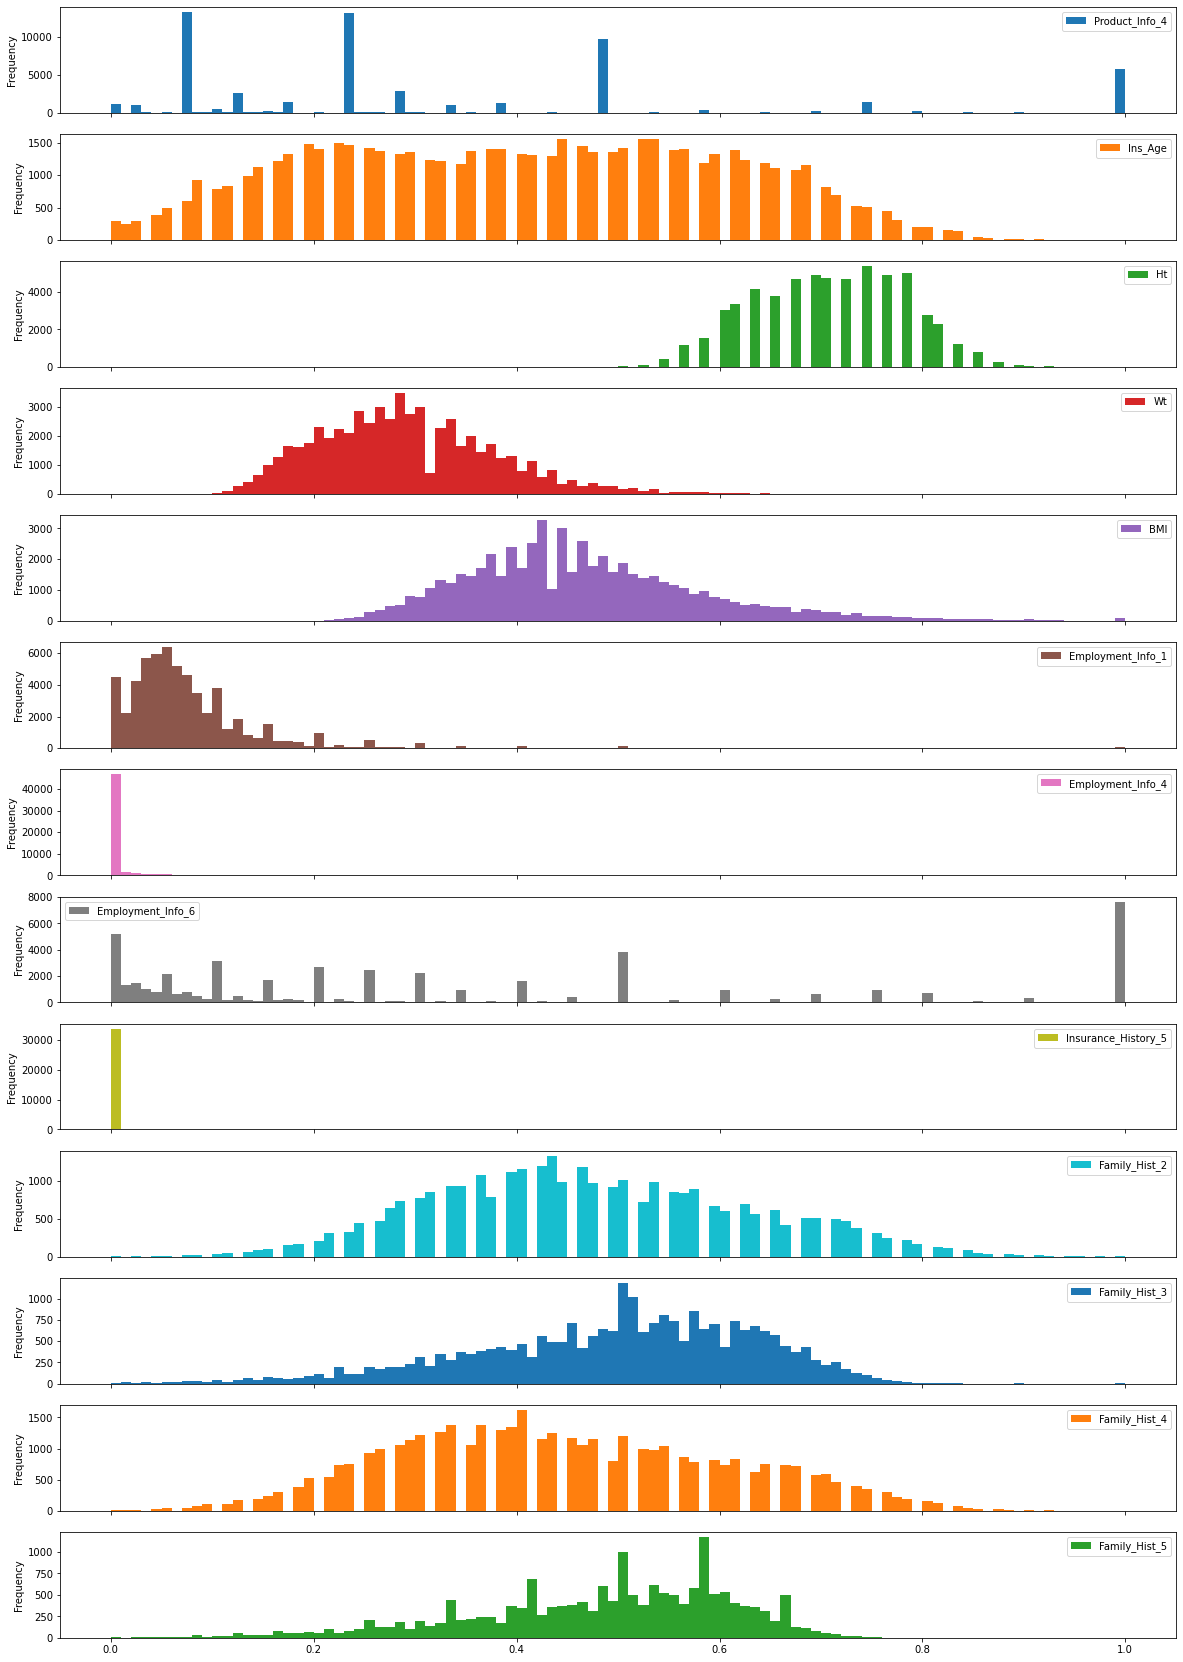

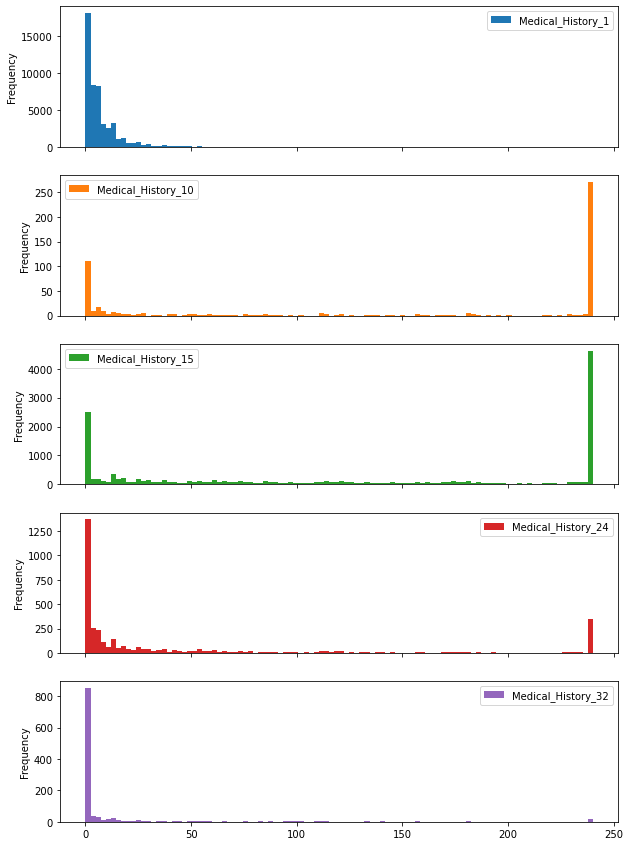

In [26]:
data[real_features].plot.hist(subplots=True, figsize=(20, 30), bins=100)

data[discrete_features].plot.hist(subplots=True, figsize=(10, 15), bins=100)

Среди вещественных есть признаки с очень большим перекосом в сторону какого-то одного значения (например, Employmennt_Info_4), возможно, их стоило бы прологарифмировать при решении задачи. Кроме того, есть признаки со сложной структурой гистограммы. 
Распределения целочисленных признаков (относящихся к группе медицинских) имеют схожую структуру. 

В целом данные разнородны, и описать их одним вероятностным распределением непросто. 

#### Попарная визуализация признаков. 

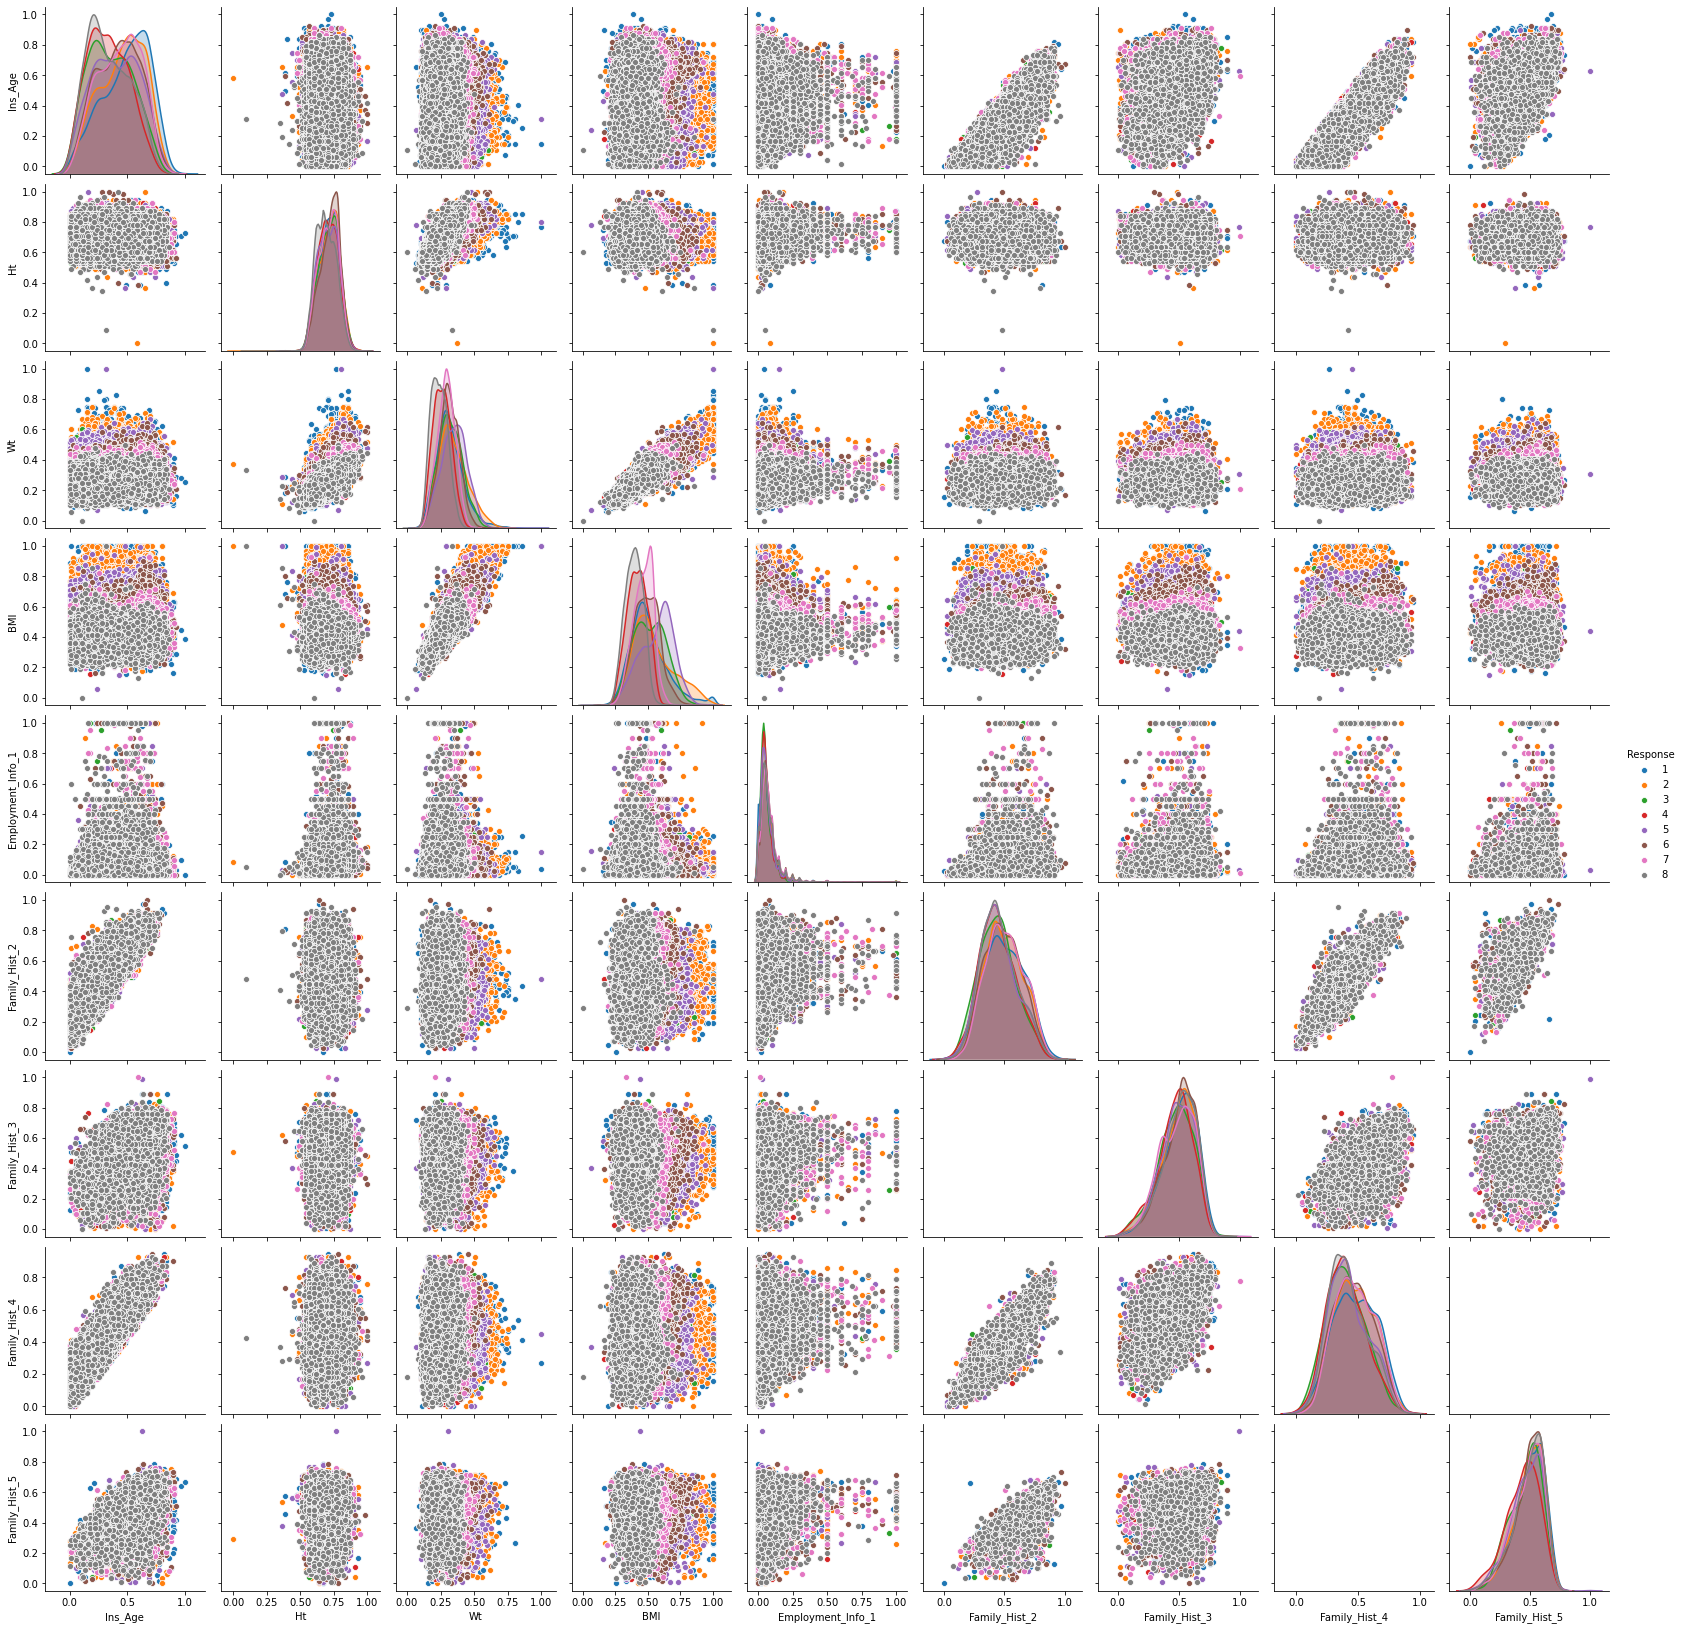

In [28]:
seaborn.pairplot(data[real_features+["Response"]].drop(
        ["Employment_Info_4", "Employment_Info_6", "Insurance_History_5", "Product_Info_4"], axis=1), 
        hue="Response", diag_kind="kde")

Теперь построим такие же графики для целочисленных признаков.

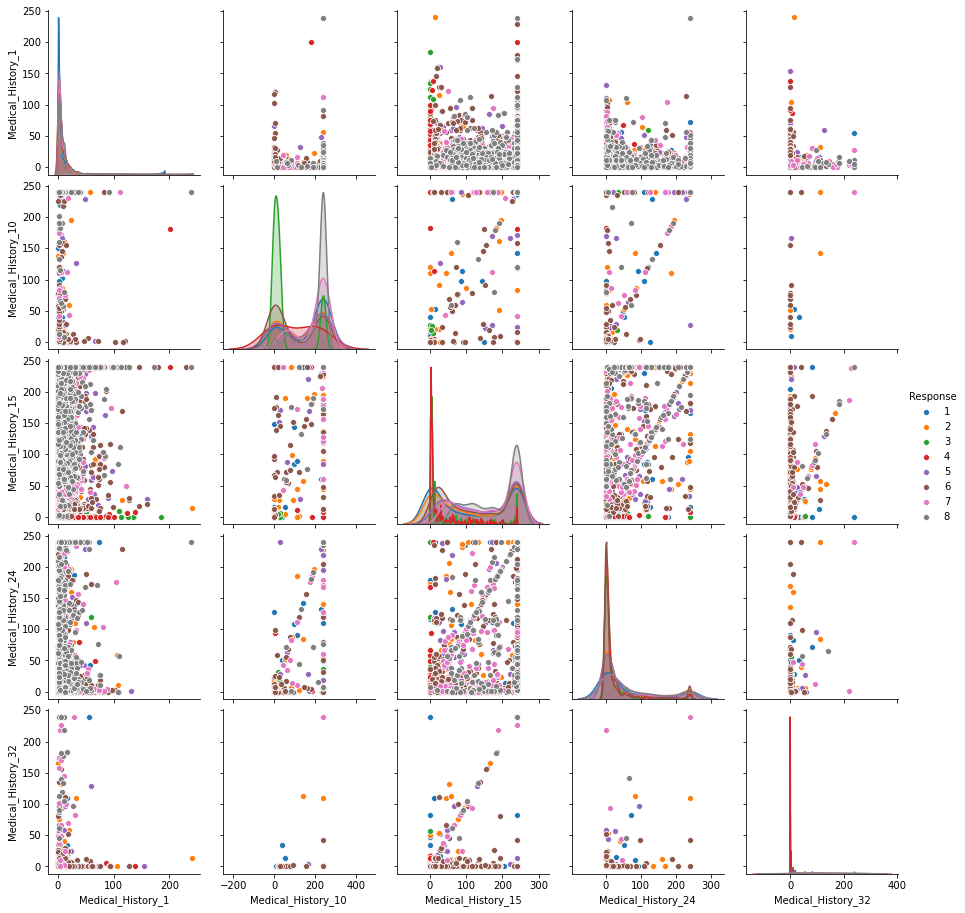

In [29]:
seaborn.pairplot(data[discrete_features+["Response"]], hue="Response", diag_kind="kde")

Графики выглядят еще менее информативно. Заметна тенденция, что пары признаков сконцентрированы либо на сторона квадрата [0, 240] x [0, 240], либо на его диагонали, то есть признаки как-то связаны.

#### Посмотрим на корреляции признаков, чтобы узнать, не нужно ли удалять какие-то признаки перед (гипотетическим) построением модели. 

Для визуализации матрицы попарных корреляций удобно использовать функцию seaborn.heatmap, она автоматически подпишет признаки на осях и покажет colorbar. Мы вычисляем корреляции только между вещественными признаками, для целочисленных признаков корреляции вычисляется по другим формулам.

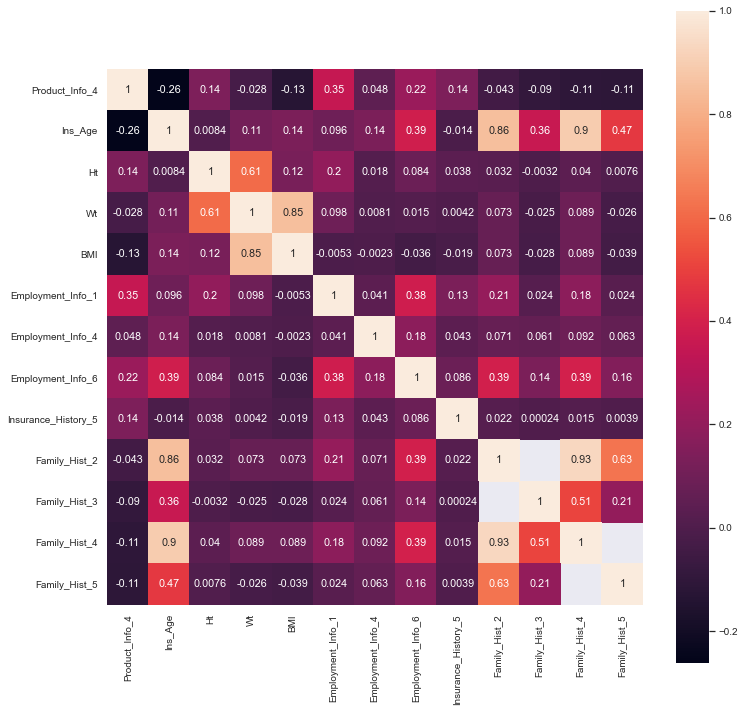

In [30]:
seaborn.set(font_scale=0.9)
fig, ax = plt.subplots(figsize=(12,12))
seaborn.heatmap(data[real_features].corr(), square=True, annot=True)

Видим, что признаки Family_Hist_4 и Family_Hist_2 сильно коррелируют

#### Посчитаем количество значений для каждого категориального признака.
Строим много графиков вручную (а не с помощью готовой функции, как с hist или pairplot). Для этого создаем новую pyplot-фигуру, указываем, сколько графиков на ней будет, задаем размер; параметр sharey говорит не подписывать все оси отдельно, а подписать их только один раз слева; здесь это уместно, потому что масштабы всех счетчиков одни и те же. 

В цикле по всем категориальным признакам строим countplot признака с помощью seaborn. Указываем параметр data, какой признак визуализировать, а также передаем ссылку на конкретную ячейку таблицы, в которой нужно изобразить график. Признаков всего 108, поэтому последние две ячейки таблицы графиков размером 11 x 10 останутся пустыми.

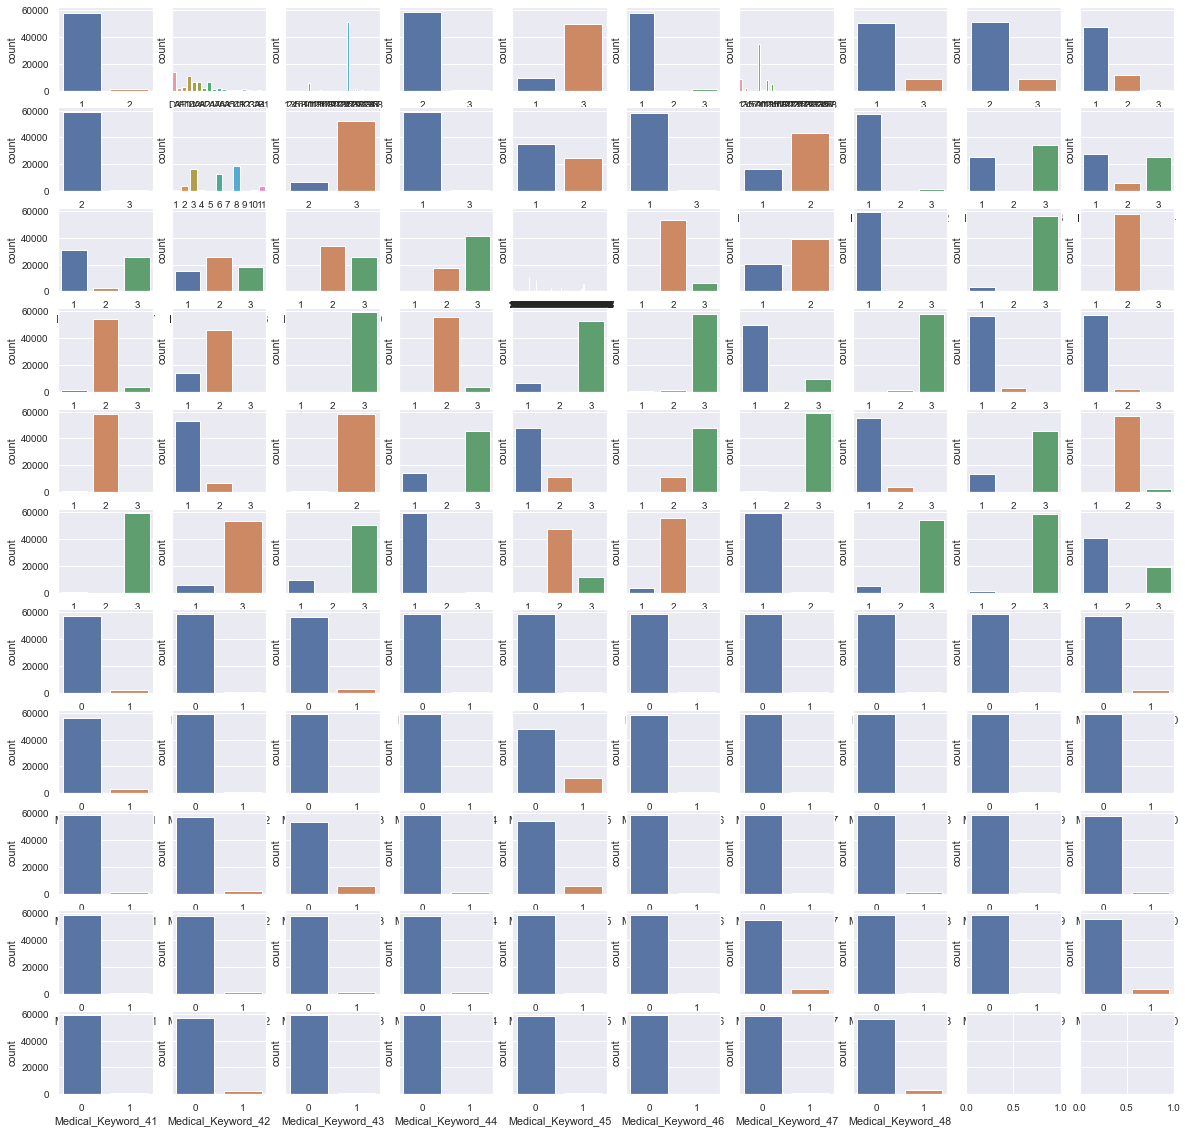

In [32]:
fig, axes = plt.subplots(11, 10, figsize=(20, 20), sharey=True)
for i in range(len(cat_features)):
    seaborn.countplot(x=cat_features[i], data=data, ax=axes[i // 10, i % 10])

У нас есть много признаков с сильными перекосами в сторону отдельного признака. Учитывая, что среди категориальных признаков много медицинских показателей, можно предположить, что именно эти признаки сильно влияют на увеличение риска (целевой признак). Проверить это предположение можно, построив такие же countplot с разбивкой каждого значения дополнительно по классам (то есть у нас будет несколько групп столбиков, и в каждой группе их будет 8). Это можно сделать, указав параметр hue в этой функции аналогично тому, как мы это делали выше.

Построим графики countplot для признаков 'Medical_Keyword_23', 'Medical_Keyword_39', 'Medical_Keyword_45' (признаки выбраны случайно) с разбивкой по классам.

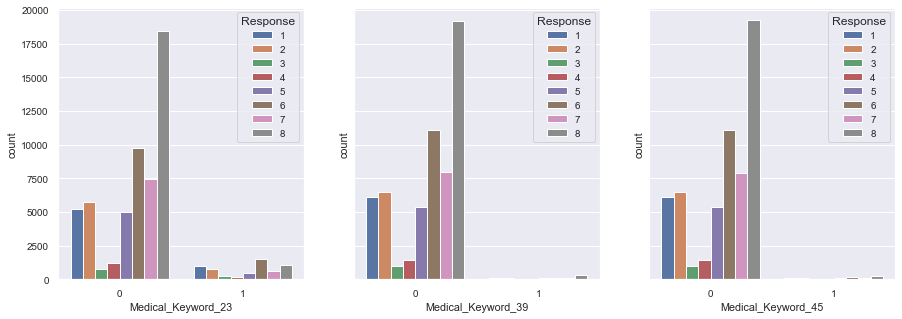

In [33]:
selected_features = ['Medical_Keyword_23', 'Medical_Keyword_39', 'Medical_Keyword_45']
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i in range(len(selected_features)):
    seaborn.countplot(x=selected_features[i], data=data, hue='Response', ax=axes[i])

Количество человек, имеющих признаки Medical_Keyword_39 и Medical_Keyword_45 и отнесенных к категории риска 8, больше, чем такая же величина для любой другой категории риска. Значит, наличие этих факторов сильно повышает риск.

#### Наконец, посмотрим на распределение целевого признака, чтобы узнать, сбалансированы ли классы:

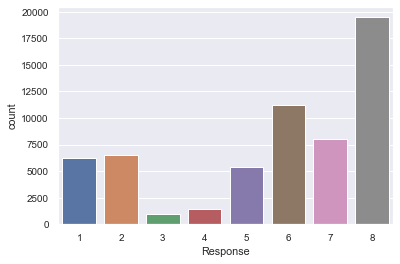

In [34]:
seaborn.countplot(data.Response)

В категорию 8 люди попадают чаще, чем в другие категории.

### Визуализация с помощью понижения размерности

Далее можно воспользоваться средствами понижения размерности. Для задачи с дискретным целевым признаком это позволит понять, какие классы хорошо разделяются, а какие - нет.

Такие методы строят матрицу попарных расстояний между объектами, которая в случае, когда объектов много, будет занимать много памяти. Кроме того, отображать много точек на scatter plot (а именно его используют для визуализации результата понижения размерности) неудобно. Поэтому мы перемешаем выборку (и далее будем использовать ее) и выберем первые 1000 объектов для понижения размерности.

In [35]:
from sklearn.utils import shuffle
from sklearn.preprocessing import scale

In [36]:
sdata = shuffle(data, random_state=321)

Методы sklearn не принимают матрицы с пропусками (nan). Чтобы избежать этой проблемы, не будем рассматривать признаки, которые имеют много пропусков (последние четыре в списке вещественных признаков). Кроме того, ограничимся рассмотрением вещественных признаков.

В следующей ячейке мы отбираем нужные признаки, затем находим объекты, у которых все признаки известны (нет пропусков в выбранных признаках), а затем создаем отдельно матрицу объекты-признаки для работы методов понижения размерности и отдельно вектор правильных ответов на этих объектах: data_subset и response_subset. Кроме того, мы дополнительно стандартизуем нашу маленькую выборку, потому что методы понижения размерности очень чувствительны к разномасштабным данным (это отдельно указано в [туториале](http://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling) в sklearn)

In [37]:
subset_l  = 1000
selected_features = real_features[:-4]
objects_with_nan = sdata.index[np.any(np.isnan(sdata[selected_features].values), axis=1)]   
data_subset = scale(sdata[selected_features].drop(objects_with_nan, axis=0)[:subset_l])
response_subset = sdata["Response"].drop(objects_with_nan, axis=0)[:subset_l]

Будем строить визуализацию методами t-SNE и MDS.

In [39]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

Методы понижения размерности имеют такой же интерфейс, как классификаторы и регрессоры. Для построения визуализации t-SNE нужно создать объект класса и вызвать его метод fit_transform, который вернет матрицу размера число объектов x новая размерность; по умолчанию новая размерность равна 2.

In [40]:
model_TSNE = TSNE(random_state=321)
tsne_representation = model_TSNE.fit_transform(data_subset)

Визуализируем полученное представление. Для этого создадим набор цветов по количеству классов, а затем в цикле по классам будем отображать представления точек, относящихся к этому классу. Будем указывать параметр alpha=0.5, чтобы сделать точки полупрозрачными, это лучше в ситуации, когда точки накладываются.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

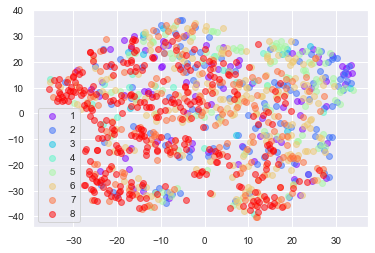

In [41]:
colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
for y, c in zip(set(data.Response), colors):
    plt.scatter(tsne_representation[response_subset.values==y, 0], 
                tsne_representation[response_subset.values==y, 1], c=c, alpha=0.5, label=str(y))
plt.legend()

Теперь сделаем то же с MDS.

In [42]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances

In [43]:
model_MDS = MDS(random_state=321)
MDS_transformed = model_MDS.fit_transform(data_subset)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

(-5.0, 5.0)

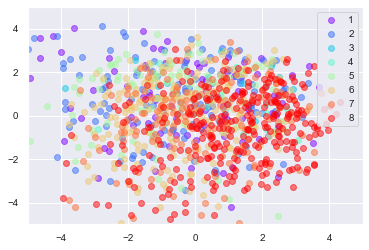

In [49]:
colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
for y, c in zip(set(response_subset), colors):
    plt.scatter(MDS_transformed[response_subset.values==y, 0], 
                MDS_transformed[response_subset.values==y, 1], 
                c=c, alpha=0.5, label=str(y))
plt.legend()
plt.xlim(-5, 5)   # масса точек концентрируется в этом масштабе
plt.ylim(-5, 5)   

Для построения представления можно пробовать разные метрики, их список доступен в [документации scipy](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html) (потому что sklearn использует метрики scipy). Вы можете попробовать использовать разные метрики в t-SNE и MDS и смотреть получающиеся визуализации, по мнению автора задания наиболее информативной выглядит визуализация MDS c косинусной метрикой ("cosine"). 

В t_SNE метрику можно указать при создании объекта класса TSNE, в MDS это реализуется несколько сложнее. Нужно указать dissimilarity="precomputed", а в fit_transform подать не матрицу объектов, а матрицу попарных расстояний между объектами. Создать ее можно с помощью функции pairwise_distances с параметрами: матрица объектов, метрика.

In [50]:
# Присвоим переменной MDS_transformed_cos результат понижения размерности методом MDS с косинусной метрикой
model_MDS_cos = MDS(dissimilarity='precomputed', random_state=321)
MDS_transformed_cos = model_MDS.fit_transform(
    pairwise_distances(data_subset, metric='cosine'))

C:\Users\ryzho\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

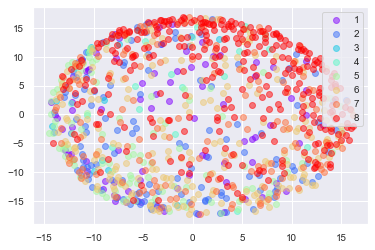

In [51]:
colors = cm.rainbow(np.linspace(0, 1, len(set(response_subset))))
for y, c in zip(set(response_subset), colors):
    plt.scatter(MDS_transformed_cos[response_subset.values[:subset_l]==y, 0], 
                MDS_transformed_cos[response_subset.values[:subset_l]==y, 1], 
                c=c, alpha=0.5, label=str(y))
plt.legend()

По графику явно видно, что объекты с наименьшим риском (1 и 2) отличаются от объектов с высоким риском (7 и 8) так ка лежат в разных частях плоскости.

Визуализации разными методами достаточно сильно отличаются, но на каждой можно условно выделить направление, вдоль которого происходит увеличение риска от 1 до 8 (то есть точки постепенно меняют цвет). Если бы это не выполнялось, можно было бы предположить, что задача не решаема.

### Поиск аномалий

##### One class SVM
Для простоты выберем вещественные признаки, которые известны для всех объектов: Product_Info_4, Ins_Age, Ht, Wt, BMI. Оставим только те, которые относятся к человеку, то есть не будем рассматривать Product_Info_4. Получится, что мы отбираем нестандартных по комбинации вес/рост/возраст людей.

In [52]:
from sklearn import svm

In [53]:
person_features = ["Ins_Age", "Ht", "Wt", "BMI"]

Два ключевых параметра OC_SVM - gamma и nu. Первый влияет на то, как хорошо граница будет приближать данные, второй - сколько точек нужно относить к выбросам. Вы можете попробовать разные значения, в том числе, значения по умолчанию, и убедиться, что при них алгоритм работает не очень адекватно. Запустите следующую ячейку, на ее выполнение может понадобиться некоторое время.

In [57]:
sdata[person_features]

,Ins_Age,Ht,Wt,BMI
31091,0.477612,0.545455,0.205021,0.486657
41552,0.208955,0.854545,0.460251,0.572082
8371,0.567164,0.672727,0.259414,0.451602
39339,0.238806,0.727273,0.257322,0.394255
38317,0.014925,0.781818,0.246862,0.331249
...,...,...,...,...
5929,0.582090,0.763636,0.456067,0.675370
43807,0.447761,0.545455,0.115063,0.281430
4220,0.776119,0.745455,0.267782,0.394875
6682,0.477612,0.690909,0.518828,0.891770


In [58]:
svm = svm.OneClassSVM(gamma=10, nu=0.01)
svm.fit(sdata[person_features])

OneClassSVM(gamma=10, nu=0.01)

In [59]:
labels = svm.predict(sdata[person_features])

In [60]:
(labels==1).mean()

0.9899631195163436

Около 98% объектов не признаются выбросами. 

Попытаемся визуализировать, какие объекты отнесены к шумовым. Для этого нужно построить scatter-графики для каждой пары признаков в person_features (всего 6 графиков). На каждом графике нужно отдельно отобразить точки с labels==1 и labels==-1. 

В цикле по __парам признаков__ из person_features отобразим scatter-графики точек (точки с разными labels разных цветов: синие, c="blue", - обычные точки, у которых labels==1, красные, c="red",  - шумовые, у которых labels==-1). Функция scatter принимает две вектора одинаковой длины, абсциссы и ординаты точек, и дополнительные параметры, например, цвет c и коэффициент прозрачности точек alpha.

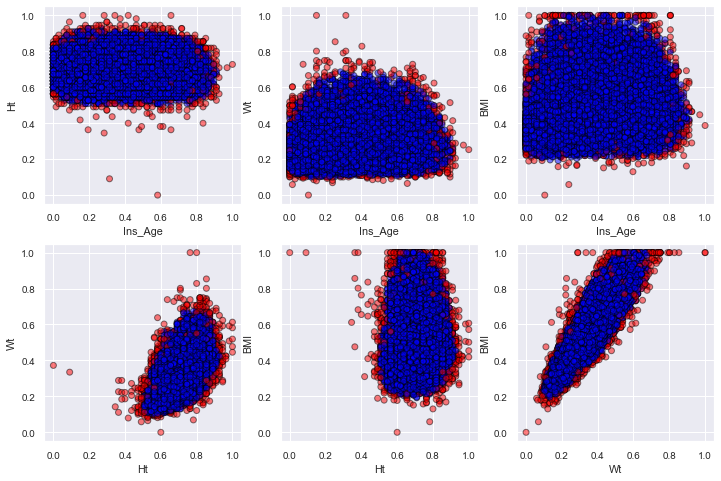

In [66]:
col = np.where(labels==1,'blue','red')
from itertools import combinations
f, ax = plt.subplots(2, 3, figsize=(12, 8))
for index, pair in enumerate(combinations(person_features, 2)):
    plt.subplot(2,3,index+1)
    plt.scatter(sdata[pair[0]], sdata[pair[1]], c=col, alpha=0.5, edgecolors = 'black')
    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

#### Непараметрическое восстановление плотности.
Искать аномалии можно, анализируя непараметрически восстановленную плотность одномерного распределения. Так можно заметить, что какие-то объекты выбиваются из общей тенденции. 

В seaborn это удобно делать с помощью метода distplot. Посмотрев на гистограммы в начале ноутбука, выберем для ближайшего рассмотрения признаки BMI, Employment_Info_1, Medical_History_32. 

Применим метод distplot к этим трем признакам, указав bins=50. 

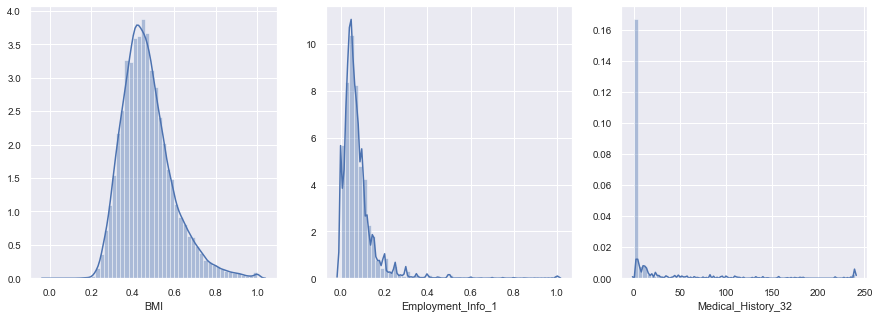

In [67]:
distplot_features = ['BMI', 'Employment_Info_1', 'Medical_History_32']
f, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(distplot_features)):
    seaborn.distplot(data[distplot_features[i]].dropna(), bins=50, ax=axes[i])

На трех графиках видно, что в конце множества значений признака есть скачок, и это явление очень похоже на аномалию.

### Заключение
Мы познакомились с методами визуализации и отбора шумовых объектов и посмотрели на примере, с чего стоит начинать работу с новым датасетом. Как и в других методах анализа данных, в методах визуализации приходится подбирать параметры, но здесь эта задача осложняется отсутствием автоматически вычисляемого критерия качества визуализации, и подбирать параметры приходится вручную.